In [70]:
import math, random, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import *

N_Docs = 1500 
N_Words = 12419
Nonzero_Counts = 746316
raw_data = pd.read_csv('data_processed.txt', delimiter = ' ')
vocab = pd.read_csv('vocab.nips.txt')

print('data read, np-ifying now')


data = np.zeros( (N_Docs, N_Words)) 
for i in tqdm_notebook(range(Nonzero_Counts)):
    data[raw_data['Doc'][i]-1][raw_data['Word'][i]-1]=raw_data['Count'][i]

print(data.shape)

#pg 234 in text


data read, np-ifying now

(1500, 12419)


In [71]:
vocab_arr = vocab.values
Word_Totals = np.zeros(N_Words)
for i in tqdm_notebook(range(N_Words)):
    Word_Totals[i] = np.sum(data[:, i])
    
zeroes = not np.nonzero(Word_Totals)

data = np.delete(data, zeroes, axis=1)
Word_Totals = np.delete(Word_Totals, zeroes, axis=0)
vocab_arr = np.delete(vocab_arr, zeroes, axis = 0)
N_Words = data.shape[1]
print(data.shape, N_Words)


#resources
#pg 234 in text
#http://www.cs.columbia.edu/~jebara/4771/tutorials/multinomial.pdf

E:\ProgramFilesE\Anaconda\lib\site-packages\numpy\lib\function_base.py:4265: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  "as boolean index instead of casting it to integer", FutureWarning)


(1500, 12418) 12418


In [72]:
#https://en.wikipedia.org/wiki/Multinomial_distribution
#n, the number of trials is the sum of a word's total appearances 
#word is a row off of the doc array, with each index corresponding to a word, and the value there being the count
#params is the probability of seeing a certain word - this is precalculated in the main flow. it is the {p1,p2,...pn}

# def logsumexp(X):
#     x_max = X.max(1)
#     return x_max + np.log(np.exp(X - x_max[:, None]).sum(1))
# def logfact(X):
#     ret = 0
#     while (X > 0):
#         ret += math.log(X)
#         X-=1
#     return ret
# def multinomial_logpdf(doc, param):
#     log_nfact =logfact(np.sum(doc))
#     log_xis = 0
#     log_probs = 0
#     for i in range(N_Words):
#         if doc[i] > 0:
#             log_xis += logfact(doc[i])
#             log_probs += math.log(param[i]) *doc[i]
# #     print(log_nfact, log_probs, log_xis)
#     return np.exp(log_nfact + log_probs - log_xis)

            


In [73]:
def Assign_Labels(data, Doc_Label_Weights, topic_params, pi):
    tmp = np.zeros(30)
    for i in tqdm_notebook(range(N_Docs)):
        for j in range(30):
            tmp[j] = np.sum(data[i,:] * np.log(topic_params[j, :]))+ np.log(pi[j])
            max = np.amax(tmp)
        denom = 0
        for j in range(30):
            denom += np.exp(tmp[j] - max)
        for j in range(30):
            num = np.exp( 
                np.sum(data[i,:] * np.log(topic_params[j,:]))
                + np.log(pi[j])-max
                      )
            Doc_Label_Weights[i][j] = num/denom
            
            
            
def estimate_params(data,Doc_Label_Weights, topic_params, pi):
    for i in tqdm_notebook(range(30)):
        p_num = np.full((N_Words), .05)
        p_denom = np.zeros(N_Words)
        for j in range(N_Docs):
            p_num += data[j] * Doc_Label_Weights[j, i]
            p_denom += np.dot(data[j], np.ones(N_Words) * Doc_Label_Weights[j][i]  )
        topic_params[i, :] = p_num/p_denom
        
        new_pi = 0
        for j in range(N_Docs):
            new_pi += Doc_Label_Weights[j][i]
        pi[i] = new_pi/N_Docs
        

In [74]:
topic_params = np.random.rand(30, N_Words)

Doc_Label_Weights = np.random.rand(N_Docs,30) #w_ij values for each word x topic combo [DDCUMENT][TOPIC]
for i in range(N_Docs):
    Doc_Label_Weights[i,:] /= np.sum(Doc_Label_Weights[i])

pi = np.zeros(30)
estimate_params(data,Doc_Label_Weights, topic_params, pi)

print("setup completed")




setup completed


In [75]:
Assign_Labels(data, Doc_Label_Weights, topic_params, pi)


In [76]:
estimate_params(data,Doc_Label_Weights, topic_params,pi)


In [77]:
old_pi = np.copy(pi)
eps = .0001

for i in range(100):
    Assign_Labels(data, Doc_Label_Weights, topic_params,pi)
    estimate_params(data,Doc_Label_Weights, topic_params,pi)
    d = np.linalg.norm(old_pi - pi)
    print("iter "+str(i) + ": " + str(d))
    if(np.linalg.norm(d) < eps):
        break
    old_pi = np.copy(pi)




iter 0: 0.0152481283197


iter 1: 0.00331214110976


iter 2: 0.00346439372205


iter 3: 0.00188277151293


iter 4: 0.000190058825778


iter 5: 0.000773403338852


iter 6: 2.42703364602e-06


[ 0.03152705  0.03552182  0.04279251  0.03615359  0.03943977  0.02472055
  0.05485927  0.03375505  0.02906707  0.03140827  0.03679283  0.03544696
  0.03028259  0.02339735  0.04289185  0.03746518  0.02541923  0.03485087
  0.02806588  0.02612083  0.0247695   0.02607998  0.04151154  0.03213428
  0.0307434   0.03453212  0.02965767  0.02952719  0.02552798  0.04553784]


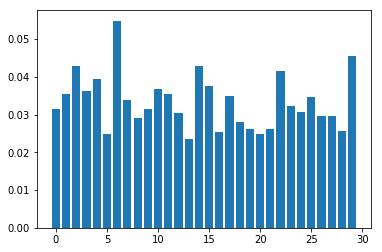

In [81]:
#Graphing time
#Produce a graph showing, for each topic, the probability with which the topic is selected.

Topic_Totals = np.zeros(30)
#Word_Labels == i
for i in range(30):
    for j in range(N_Docs):
        Topic_Totals[i] += Doc_Label_Weights[j][i]
Topic_Totals /= np.sum(Topic_Totals)
print(Topic_Totals)

plt.figure(1)
plt.bar(left = range(0,30), height = Topic_Totals)

# plt.figure(2)
# plt.pie(Topic_Totals)
# I thought the pie chart might be amusing at least, it's not even that. Turns out 30 is too many ways to split a pizza
plt.show(block = False)


In [82]:
# %pprint


In [80]:
Topic_TopTens = np.zeros((30,10),dtype = np.int32)
for i in range(30):
#     ten = np.argpartition(topic_params[i], N_Docs - 10, axis = 0)[N_Docs-11:N_Docs-1]
# #     print(ten)
#     print(np.sort(topic_params[i]))
#     ten_sorted = np.argsort(topic_params[i][ten])#sorts in ASCENDING order
#     print(topic_params[i][ten])
# We were doing argpartition + trying to sort the remainder (returning indices sorted on the values of those indices in another array gets messy), but it's really not much faster than just finding the max 10 times.
    for j in range(10):
        Topic_TopTens[i][j] = np.argmax(topic_params[i, :])
        topic_params[i][np.argmax(topic_params[i, :]) ] = 0
        
# for i in range(30):
#     print("Topic Number: " + str(i))
#     for j in range(9,-1,-1):
#         print(str(j) +' : '+ vocab['a2i'][Topic_TopTens[i][j]])
#     print("\n")

# print(Topic_TopTens)
from tabulate import tabulate
print(tabulate(
    [['Topic Number','Most Common', "2nd Most Common" + "3rd"] + [str(i)+'th' for i in range(4,11)]] +
    [ [i] + [vocab_arr[j] for j in Topic_TopTens[i]] for i in range(10)]

))


------------  ------------  ------------------  ---------------  --------------  --------------  ---------------  ----------------  ------------------  ---------------  -----------------
Topic Number  Most Common   2nd Most Common3rd  4th              5th             6th             7th              8th               9th                 10th
0             ['netxvork']  ['unitary']         ['inquiry']      ['modeled']     ['weighted']    ['hierar']       ['neurally']      ['functional']      ['learnt']       ['outseg']
1             ['modeled']   ['cellular']        ['inquiry']      ['netxvork']    ['neuronal']    ['systematic']   ['learnt']        ['functional']      ['patterned']    ['unitary']
2             ['netxvork']  ['learnt']          ['algorithmic']  ['functional']  ['weighted']    ['setpoint']     ['unitary']       ['trajec']          ['problematic']  ['modeled']
3             ['netxvork']  ['modeled']         ['database']     ['setpoint']    ['functional']  ['algorithmic']  